# Assignment 3 - Epipolar Geometry
**Author:** Johannes Holmgren

In [1]:
# Import external modules
# Uncomment below to have interactive 3D models
# %matplotlib widget
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy.linalg import null_space, inv, qr
import cv2
from skimage import transform

# Import internal modules/files
import plotter
import utils

In [2]:
# ----- Constants -----
MAT_PATH = 'data/mat/'      # Path to data
IMG_PATH = 'data/images/'   # Path to images
# ---------------------

----- Using normalization -----
Smallest singular value: 0.0497
||Mv|| = 0.0497
The epipolar constraints are fulfilled with epsilon = 0.2
Mean distance is 18.3463
----- Without normalization -----
Smallest singular value: 0.5629
||Mv|| = 0.5629
The epipolar constraints are fulfilled with epsilon = 1.9
Mean distance is 34.5235


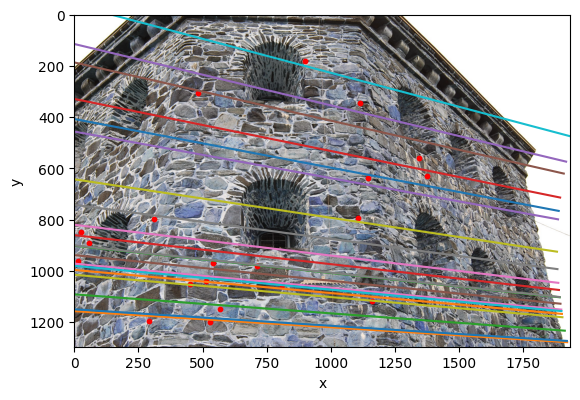

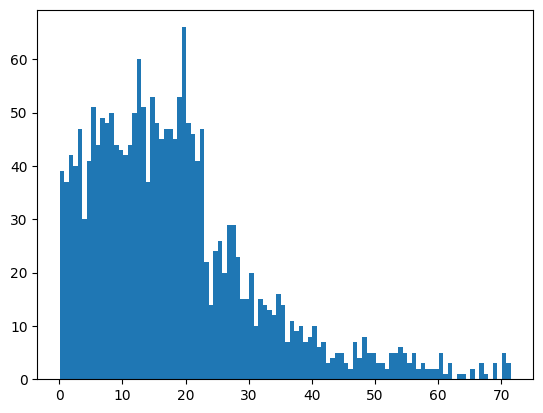

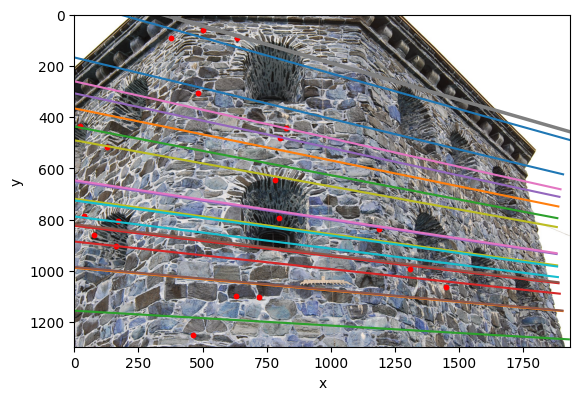

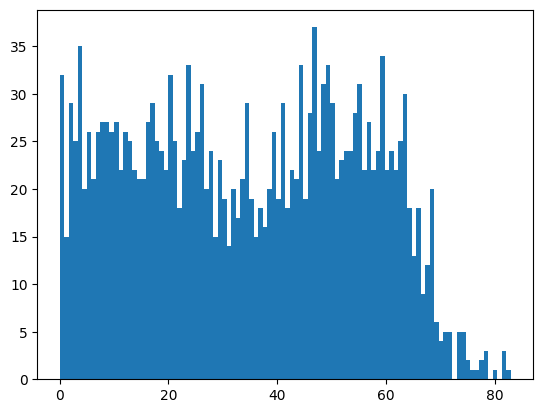

In [ ]:
def estimate_F_DLT(x1s, x2s):
    ''' Solve Homogeneous least squares for DLT equations using SVD.
        Use this result to find the fundamental camera F
    
    Parameters
    ----------
    x1s: np.ndarray
        The image points for camera 1

    x2s: np.ndarray
        The image points for camera 2

    Returns
    -------
    np.ndarray
        The v-vector from the solution min(||Mv||),
        which contains the camera matrix P as its first 12 elements.
    '''
    # Set up matrix M
    n_points = x1s.shape[1]
    dim = x1s.shape[0]
    M = np.zeros([n_points, dim * dim])
    for i in range(n_points):
        xx = np.outer(x1s[:,i], x2s[:,i])
        M[i,:] = xx.flatten()
    # Solve least squares problem
    U, S, Vh = np.linalg.svd(M)
    v = Vh[-1]
    sv_min = S[-1]
    F = v.reshape((3, 3))
    return (F, M, v, sv_min)

def enforce_fundamental(F_approx: np.ndarray) -> np.ndarray:
    ''' Enforce fundamental matrix to have zero determinant
    
    Does this by performing SVD and setting the minimum singular value
    to 0 before recreating F.

    Parameters
    ----------
    F_approx: np.ndarray
        The approximated fundamental matrix F
    
    Returns
    -------
    np.ndarray:
        The fundamental matrix F with zero determinant
    '''
    U, S, Vh = np.linalg.svd(F_approx)
    S[-1] = 0
    S_diag = np.diag(S)
    F = np.matmul(U, np.matmul(S_diag, Vh))
    return F

def psphere(v):
    ''' Normalize vectors to lie on the unit sphere. '''
    norms = np.linalg.norm(v, axis=0)
    return v / norms

def rital(ax: plt.axes, lines: np.ndarray):
    ''' Draw lines in an image
    
    Parameters
    ----------
    ax: plt.axes
        The matplotlib.pyplot axis to plot in

    lines: np.ndarray
        The homogeneous lines to plot
    
    '''
    if lines.size == 0:
        return
    n_lines = lines.shape[1]
    # Compute direction vectors orthogonal to the lines
    directions = psphere(np.array([lines[1,:], -lines[0,:], np.zeros(n_lines)]))
    # Compute points on the lines by finding intersection with z=0
    points = utils.pflat(np.cross(directions.T, lines.T).T)
    for i in range(n_lines):
        x_vals = [points[0, i] - 2000 * directions[0, i], points[0, i] + 2000 * directions[0, i]]
        y_vals = [points[1, i] - 2000 * directions[1, i], points[1, i] + 2000 * directions[1, i]]
        ax.plot(x_vals, y_vals)

def compute_epipolar_errors(F: np.ndarray, x1s: np.ndarray, x2s: np.ndarray):
    ''' Compute distance between points and their corresponding epipolar lines 
    
    Parameters
    ----------
    F: np.ndarray
        The fundamental matrix

    x1s: np.ndarray
        Image points in image 1

    x2s: np.ndarray
        Image points in image 2

    '''
    lines = np.matmul(F, x1s)
    distances = utils.point_line_distance2D(x2s, lines)
    return distances

# Computer Exercise 1
# ----- Load data -----
compEx1data = loadmat(MAT_PATH + 'compEx1data.mat')
x1       = compEx1data['x'][:,0][0]
x2       = compEx1data['x'][:,0][1]
kronan1 = cv2.imread(IMG_PATH + 'kronan1.JPG')
kronan2 = cv2.imread(IMG_PATH + 'kronan2.JPG')
# ---------------------

# ----- Part 1 -----
print('----- Using normalization -----')
# Normalize x1 and x2
N1 = utils.get_normalization_matrix(x1)
N2 = utils.get_normalization_matrix(x2)
x1_norm = np.matmul(N1, x1)
x2_norm = np.matmul(N2, x2)

# Construct normalized fundamental matrix F using SVD
F_approx, M, v, sv_min = estimate_F_DLT(x1_norm, x2_norm)

# Information regarding the result
Mv_norm = np.linalg.norm(np.matmul(M, v))
print(f'Smallest singular value: {round(sv_min, 4)}')
print(f'||Mv|| = {round(Mv_norm, 4)}')

# Set F to closest matrix with determinant 0
F_norm = enforce_fundamental(F_approx)

# Check that epipolar constraint is fulfilled
EPS = 0.2
passed = True
for i in range(x1_norm.shape[1]):
    constraint = abs(np.matmul(x2_norm[:,i].T, np.matmul(F_norm, x1_norm[:,i])))
    if constraint > EPS:
        passed = False
if passed:
    print(f'The epipolar constraints are fulfilled with epsilon = {EPS}')
else:
    print(f'The epipolar constraints are not fulfilled with epsilon = {EPS}')

# Compute the unnormalized fundamental matrix F
F = np.matmul(N2.T, np.matmul(F_norm, N1))

# Compute epipolar lines for x1 and normalize
l = np.matmul(F, x1)
l = utils.pflat(l)
l_norms = np.sqrt(l[0, :]**2 + l[1,:]**2)
l = l / l_norms

# Pick 20 random points in image 2 and find their respective lines
n_points = 20
indices = np.random.choice(x2.shape[1], n_points)
points = x2[:,indices]
lines = l[:,indices]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, kronan2.shape[1])
ax.set_ylim(kronan2.shape[0], 0)
ax.imshow(kronan2)
rital(ax, lines)
plotter.plot_points_2D(ax, points, s=10, c='r')

### Answer: The lines and the points seem relatively close, but not exactly.

# Compute the distances between points and their corresponding epipolar lines
errors = compute_epipolar_errors(F, x1, x2)
print(f'Mean distance is {round(np.mean(errors), 4)}')

# Plot distances in a histogram with 100 bins
N_BINS = 100
fig, ax = plt.subplots()
ax.hist(errors, bins=N_BINS)

# ----- Part 2 -----
print('\n---- Without normalization ----')
# Do everything but with N1 = N2 = I
N1 = np.identity(3)
N2 = np.identity(3)
x1_norm = np.matmul(N1, x1)
x2_norm = np.matmul(N2, x2)

# Construct normalized fundamental matrix F using SVD
F_approx, M, v, sv_min = estimate_F_DLT(x1_norm, x2_norm)

# Information regarding the result
Mv_norm = np.linalg.norm(np.matmul(M, v))
print(f'Smallest singular value: {round(sv_min, 4)}')
print(f'||Mv|| = {round(Mv_norm, 4)}')

# Set F to closest matrix with determinant 0
F_norm = enforce_fundamental(F_approx)

# Check that epipolar constraint is fulfilled
EPS = 1.9
passed = True
for i in range(x1_norm.shape[1]):
    constraint = abs(np.matmul(x2_norm[:,i].T, np.matmul(F_norm, x1_norm[:,i])))
    if constraint > EPS:
        passed = False
if passed:
    print(f'The epipolar constraints are fulfilled with epsilon = {EPS}')
else:
    print(f'The epipolar constraints are not fulfilled with epsilon = {EPS}')

# Compute the unnormalized fundamental matrix F
F = np.matmul(N2.T, np.matmul(F_norm, N1))

# Compute epipolar lines for x1 and normalize
l = np.matmul(F, x1)
l = utils.pflat(l)
l_norms = np.sqrt(l[0, :]**2 + l[1,:]**2)
l = l / l_norms

# Pick 20 random points in image 2 and find their respective lines
n_points = 20
indices = np.random.choice(x2.shape[1], n_points)
points = x2[:,indices]
lines = l[:,indices]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, kronan2.shape[1])
ax.set_ylim(kronan2.shape[0], 0)
ax.imshow(kronan2)
rital(ax, lines)
plotter.plot_points_2D(ax, points, s=10, c='r')

### Answer: The lines and the points seem a bit further away

# Compute the distances between points and their corresponding epipolar lines
errors = compute_epipolar_errors(F, x1, x2)
print(f'Mean distance is {round(np.mean(errors), 4)}')

# Plot distances in a histogram with 100 bins
N_BINS = 100
fig, ax = plt.subplots()
ax.hist(errors, bins=N_BINS)

# Show everything
plt.show()